Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading client data...
  Client 1: 314 samples, Classes: [ 0  3  4  5  6  8 10]
  Client 2: 113 samples, Classes: [1 6]
  Client 3: 365 samples, Classes: [ 1  3  7  8  9 10]
  Client 4: 207 samples, Classes: [0 5 8]
  Client 5: 209 samples, Classes: [2 5 7]
  Client 6: 202 samples, Classes: [ 4  5 11]
  Client 7: 448 samples, Classes: [ 0  3  4  7  8  9 10 11]
  Client 8: 142 samples, Classes: [ 4  5  8 10]
  Client 9: 412 samples, Classes: [ 0  1  5  7  8 10 11]
  Client 10: 64 samples, Classes: [1 4 6]

Test data: 500 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Preprocessing data...
Data normalized. Verifying no NaN values...

Starting training on cpu...

=== Round 1/60 ===
  Training Client 2...
  Training Client 1...
  Training Client 5...
  Training Client 10...
  Training Client 7...
  Training Client 6...
  Training Client 9...

Test Accur

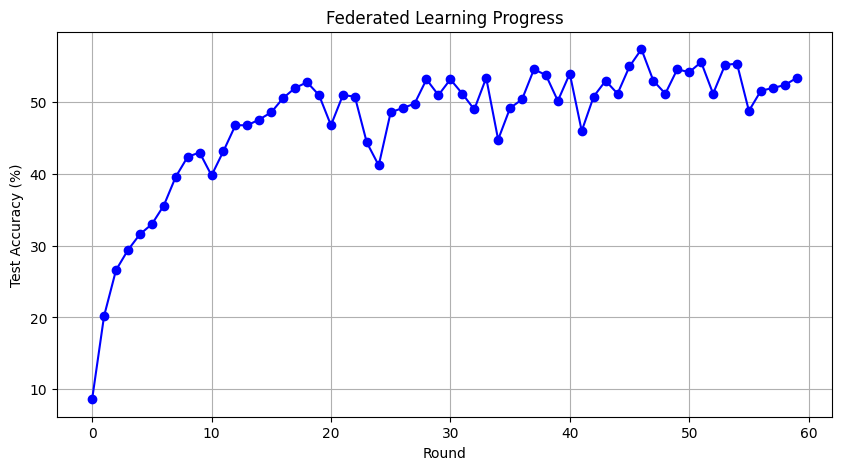

In [14]:
# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/AAX2/Seminar 5'

# Set random seeds for reproducibility
def set_random_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds(42)

# ============================================================================
# PART 2: DATA LOADING AND PREPROCESSING
# ============================================================================
def load_csi_data(data_dir):
    client_data = {}
    print("Loading client data...")

    for client_id in range(1, 11):
        X_path = os.path.join(data_dir, f'client_{client_id}_features.csv')
        y_path = os.path.join(data_dir, f'client_{client_id}_labels.csv')

        X = pd.read_csv(X_path, header=None).values
        y = pd.read_csv(y_path, header=None).values.flatten() - 1  # Convert to 0-11

        client_data[client_id] = {'X': X, 'y': y, 'original_size': len(X)}
        print(f"  Client {client_id}: {len(X)} samples, Classes: {np.unique(y)}")

    # Load test data
    X_test = pd.read_csv(os.path.join(data_dir, 'test_features.csv'), header=None).values
    y_test = pd.read_csv(os.path.join(data_dir, 'test_labels.csv'), header=None).values.flatten() - 1

    print(f"\nTest data: {len(X_test)} samples, Classes: {np.unique(y_test)}")
    return client_data, X_test, y_test

def preprocess_data(client_data, X_test, y_test):
    print("\nPreprocessing data...")

    # Combine all training data for scaling
    all_train = np.vstack([data['X'] for data in client_data.values()])
    scaler = StandardScaler().fit(all_train)

    # Normalize client data
    for client_id in client_data:
        client_data[client_id]['X'] = scaler.transform(client_data[client_id]['X'])

    # Normalize test data
    X_test = scaler.transform(X_test)

    print("Data normalized. Verifying no NaN values...")
    for client_id in client_data:
        assert not np.any(np.isnan(client_data[client_id]['X']))
    assert not np.any(np.isnan(X_test))

    return client_data, X_test, y_test

# ============================================================================
# PART 3: MODEL ARCHITECTURE
# ============================================================================
class PoseClassifier(nn.Module):
    def __init__(self, input_dim=270, num_classes=12, dropout_rate=0.4):
        super().__init__()
        self.input_bn = nn.BatchNorm1d(input_dim)

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate*0.8),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate*0.6),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate*0.4)
        )

        self.classifier = nn.Linear(64, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if x.size(0) > 1:  # Only apply batch norm if batch size > 1
            x = self.input_bn(x)
        features = self.feature_extractor(x)
        return self.classifier(features)

# ============================================================================
# PART 4: TRAINING UTILITIES
# ============================================================================
def calculate_class_weights(y, num_classes=12, smoothing=0.1):
    counts = np.bincount(y, minlength=num_classes)
    weights = len(y) / (num_classes * np.maximum(counts, 1))
    return torch.FloatTensor(weights * (1 - smoothing) + smoothing)

def create_balanced_dataset(X, y, min_samples=20):
    balanced_X, balanced_y = [], []
    for class_id in range(12):
        idx = np.where(y == class_id)[0]
        if len(idx) > 0:
            n_samples = max(min_samples, len(idx))
            selected = np.random.choice(idx, n_samples, replace=len(idx) < n_samples)
            balanced_X.append(X[selected])
            balanced_y.append(y[selected])
    return np.vstack(balanced_X), np.concatenate(balanced_y)

# ============================================================================
# PART 5: FEDERATED LEARNING CORE
# ============================================================================
def federated_learning(client_data, X_test, y_test, num_rounds=60, clients_per_round=7,
                     local_epochs=15, batch_size=32, lr=0.002, device='cuda'):

    model = PoseClassifier().to(device)
    global_state = deepcopy(model.state_dict())
    best_acc, best_state = 0.0, None
    history = []

    for round_num in range(num_rounds):
        print(f"\n=== Round {round_num+1}/{num_rounds} ===")

        # Client selection
        selected = random.sample(list(client_data.keys()), clients_per_round)
        local_states, local_sizes = [], []

        for client_id in selected:
            print(f"  Training Client {client_id}...")
            X, y = client_data[client_id]['X'], client_data[client_id]['y']

            # Balance client data
            X_bal, y_bal = create_balanced_dataset(X, y)

            # Convert to tensors
            X_tensor = torch.FloatTensor(X_bal).to(device)
            y_tensor = torch.LongTensor(y_bal).to(device)
            dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

            # Create loader with drop_last=True to avoid batch size 1
            loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=True, drop_last=True)

            # Local training
            model.load_state_dict(global_state)
            model.train()
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss(weight=calculate_class_weights(y_bal).to(device))

            for epoch in range(local_epochs):
                for batch_X, batch_y in loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

            local_states.append(deepcopy(model.state_dict()))
            local_sizes.append(len(X_bal))

        # Aggregate with momentum
        new_global = deepcopy(local_states[0])
        momentum = 0.1 if round_num > 10 else 0.05
        total_size = sum(local_sizes)

        for key in new_global:
            new_global[key] = sum(
                state[key] * (size/total_size)
                for state, size in zip(local_states, local_sizes)
            )
            if round_num > 0:
                new_global[key] = (1-momentum)*new_global[key] + momentum*global_state[key]

        global_state = new_global

        # Evaluation
        model.load_state_dict(global_state)
        test_acc = evaluate_model(model, X_test, y_test, device)
        history.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_state = deepcopy(global_state)
            print(f"  New best accuracy: {best_acc:.2f}%")

    # Return best model
    model.load_state_dict(best_state)
    return model, history

def evaluate_model(model, X_test, y_test, device, verbose=True):
    model.eval()
    X_tensor = torch.FloatTensor(X_test).to(device)
    y_tensor = torch.LongTensor(y_test).to(device)

    with torch.no_grad():
        outputs = model(X_tensor)
        _, preds = torch.max(outputs, 1)
        acc = (preds == y_tensor).float().mean().item() * 100

    if verbose:
        print(f"\nTest Accuracy: {acc:.2f}%")
        print("Class-wise Performance:")
        for class_id in range(12):
            idx = y_test == class_id
            if idx.sum() > 0:
                class_acc = (preds[idx] == y_tensor[idx]).float().mean().item() * 100
                print(f"  Class {class_id}: {class_acc:.1f}% ({idx.sum()} samples)")

    return acc

# ============================================================================
# PART 6: MAIN EXECUTION
# ============================================================================
if __name__ == "__main__":

    # Load and preprocess data
    client_data, X_test, y_test = load_csi_data(data_dir)
    client_data, X_test, y_test = preprocess_data(client_data, X_test, y_test)

    # Run federated learning
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nStarting training on {device}...")

    model, history = federated_learning(
        client_data=client_data,
        X_test=X_test,
        y_test=y_test,
        num_rounds=60,
        clients_per_round=7,
        local_epochs=15,
        batch_size=32,
        lr=0.002,
        device=device
    )

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(history, 'b-o')
    plt.title("Federated Learning Progress")
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True)
    plt.show()